In [13]:
import numpy as np
import scipy
from scipy import linalg
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import functools as ftls
import networkx as nx
import copy
from itertools import combinations
%matplotlib inline
import sys
from IPython.display import display, HTML
display(HTML('<style>.container { width:90% !important; }</style>'))
np.set_printoptions(threshold=sys.maxsize)

X = np.array([[0.0, 1.0], [1.0, 0.0]])
Y = np.array([[0.0,-1.0j],[1.0j,0.0]], dtype = 'complex')
Z = np.array([[1.0, 0.0], [0.0, -1.0]])
I = np.array([[1.0, 0.0], [0.0, 1.0]])

In [14]:
def new_graph(d, n):
    graph = nx.random_regular_graph(d, n)
    return graph, d, n

def random_graph(d, n):
    #graph = nx.erdos_renyi_graph(n, 0.25)
    graph = nx.gnm_random_graph(n, d)
    return graph, d, n

def isomorphism_check(x, y):
    isomorphic = nx.is_isomorphic(x, y)
    return isomorphic

def is_graph_connected(g):
    connected = nx.is_connected(g)
    return connected

def is_graph_regular(g, k):
    regular = nx.is_k_regular(g, k)
    return regular

def isomorphism(graphs):
    graph_list = graphs
    check = True
    graphs = copy.deepcopy(graph_list)
    while (check) and (len(graphs) > 1):
        for i, j in combinations(graphs, 2):
            check = isomorphism_check(i[0], j[0])
            if check:
                graphs.remove(i)
                break
            print(len(graphs))
            return graphs

def generate_graphs(num_edges, num_nodes, num_graphs):
    graph_list = []
    connected_graphs = []
    regular_graphs = []
    graph_only =[]
    if num_nodes < 4 and num_edges < 2:
        graph_only.append(new_graph(num_edges,num_nodes))
        return graph_only
    else :
        for i in range(num_graphs):
            graph_list.append(new_graph(num_edges,num_nodes))
        for i in range(len(graph_list)):
            if (is_graph_regular(graph_list[i][0], num_edges)):
                regular_graphs.append(graph_list[i])
        for i in range(len(regular_graphs)):
            if (is_graph_connected(regular_graphs[i][0])):
                connected_graphs.append(regular_graphs[i])
        check = True
        graphs = copy.deepcopy(connected_graphs)
        while (check) and (len(graphs) > 1):
            for i, j in combinations(graphs, 2):
                check = isomorphism_check(i[0], j[0])
                if check:
                    graphs.remove(i)
                    break
        return graphs
    
# def generate_graphs(num_edges, num_nodes, num_graphs):
#     graph_list = []
#     graph_only =[]
#     if num_nodes < 4 and num_edges < 2:
#         graph_only.append(new_graph(num_edges,num_nodes))
#         return graph_only
#     else :
#         for i in range(num_graphs):
#             graph_list.append(random_graph(num_edges,num_nodes))
#         check = True
#         graphs = copy.deepcopy(graph_list)
#         while (check) and (len(graphs) > 1):
#             for i, j in combinations(graphs, 2):
#                 check = isomorphism_check(i[0], j[0])
#                 if check:
#                     graphs.remove(i)
#                     break
#         return graphs

In [15]:
def MaxCut_p(edges, qubits, operator):
    H_problem = np.zeros([2**qubits,2**qubits], dtype=operator.dtype)
    for edge in edges:
        edge = np.sort(edge)
        H_problem += (np.real(ftls.reduce(np.kron, [np.eye(2**edge[0]), operator, 
                                   np.eye(2**(edge[1]-edge[0]-1)),
                                   operator, np.eye(2**(qubits-edge[1]-1))]))) * (-1/2)
    if np.isreal(H_problem).all():
        H_problem = H_problem.real
    return H_problem

def MaxClique_p(edges, qubits, operator):
    H_problem = np.zeros([2**qubits,2**qubits], dtype=operator.dtype)
    graph = nx.Graph(edges)
    graph_c = nx.complement(graph)
    edges_c = graph_c.edges
    max_degree = sorted(graph_c.degree, key=lambda k: [k[1], k[0]])
    print(max_degree)
    if (max_degree[-1][1]) < (qubits/2):
        A = max_degree[-1][1]
    else:
        A = qubits/2
    print("Max Degree: " + str(max_degree[-1][1]))
    print("A:" + str(A))
    for edge in edges_c:
        edge = np.sort(edge)
        H_problem += (1/4) * (np.real(ftls.reduce(np.kron, 
                                   [np.eye(2**edge[0]), operator, np.eye(2**(edge[1]-edge[0]-1)), operator, np.eye(2**(qubits-edge[1]-1))]) -
                                   ftls.reduce(np.kron, [np.eye(2**edge[0]), operator, np.eye(2**(qubits-edge[0]-1))]) -
                                   ftls.reduce(np.kron, [np.eye(2**(edge[1])), operator, np.eye(2**(qubits-edge[1]-1))])))
    for j in range(qubits):
        H_problem += 1/1 * (ftls.reduce(np.kron, [np.eye(2**j), operator, np.eye(2**(qubits-j-1))]))
    if np.isreal(H_problem).all():
        H_problem = H_problem.real
    return H_problem

def Hamiltonian_d(qubits, operator):
    H_driver = np.zeros([2**qubits]*2, dtype = operator.dtype)
    for j in range(qubits):
        H_driver += 1.0 * ftls.reduce(np.kron, [np.eye(2**j), operator, np.eye(2**(qubits-j-1))])
    return H_driver

def eigenV(Hamilt):
    eigenValues, eigenVectors = np.linalg.eigh(Hamilt)
    return eigenVectors, eigenValues

def commutator(A, B, anti = False):
    if not anti:
        return A @ B - B @ A
    elif anti:
        return A @ B + B @ A

def exeFALQON(graphs, qubits):
    h_p_values = []
    graph_for_FALQON =[]
    beta_values = []
    cost_function_values = []
    phi_values = []
    psi_values = []
    H_p_eigenValues = []
    g = 0
    print(len(graphs))
    H_d = Hamiltonian_d(qubits, X)
    eigenVectors_d, eigenValues_d = eigenV(H_d)
    for g in range(len(graphs)):
        graph_for_FALQON = graphs[g]
        H_p = MaxCut_p(graph_for_FALQON[0].edges, qubits, Z)
        #H_p = MaxClique_p(graph_for_FALQON[0].edges, qubits, Z)
        h_p_values.append(H_p)
        eigenVectors_p, eigenValues_p = eigenV(H_p)
        dt = 0.03
        n_steps = 500
        beta = [0]
        psi_list = []
        phi_list = []
        
        psi_0 = eigenVectors_d[:, 0]
        U_p = np.exp(-1j*np.diag(H_p)*dt) #1d array
        comm = (1j*commutator(H_d, H_p, anti = False))
        cost_function = [float(np.real(np.conj(np.transpose(psi_0)) @ H_p @ psi_0))]#
        U_d = linalg.expm(-1j*beta[0]*H_d*dt)
        psi = U_d @ (U_p*psi_0) #2d array
        A = float(np.real(np.conj(np.transpose(psi)) @ comm @ psi))
        beta.append(-A) #Add -A to beta array
        cost_function.append(float(np.real(np.conj(np.transpose(psi)) @ H_p @ psi)))#
    
        i = 1
        while i < n_steps:
            U_d = linalg.expm(-1j*beta[i]*H_d*dt)
            psi = U_d @ (U_p*psi) #2d array
            A = float((np.real(np.conj(np.transpose(psi)) @ comm @ psi)))
            beta.append(-A)
            cost_function.append(float(np.real(np.conj(np.transpose(psi)) @ H_p @ psi)))#
            psi_list.append(psi)
        
            k = 0
            phi = 0
            for k in range(len(eigenValues_p)):
                if eigenValues_p[0] == eigenValues_p[k]:
                    phi =+ phi + ((np.absolute(np.vdot(eigenVectors_p[:,k], psi)))**2)
            phi_list.append(phi)
            i = i+1
        beta_values.append(beta)
        cost_function_values.append(cost_function)
        phi_values.append(phi_list)
        psi_values.append(psi_list)
        H_p_eigenValues.append(eigenValues_p)
    return beta_values, cost_function_values, phi_values, H_p_eigenValues, graphs

In [16]:
k = 2
qubits = 4
num_graphs = 1
graphs = generate_graphs(k, qubits, num_graphs)
print(len(graphs))

1


In [17]:
beta, cost_function, phi_list, eigenValues_p, num_graphs = exeFALQON(graphs, qubits)

1


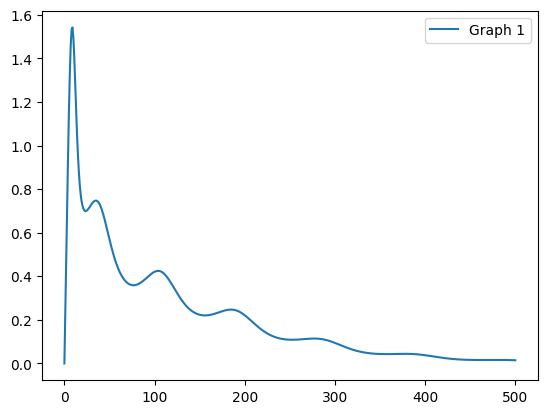

In [18]:
plt.plot(beta[0], label = "Graph 1")
# plt.plot(beta[1], label = "Graph 2")
# plt.plot(beta[2], label = "Graph 3")
#plt.plot(beta[3], label = "Graph 4")
#plt.plot(beta[4], label = "Graph 5")
#plt.plot(beta[5], label = "Graph 6")
#plt.plot(beta[6], label = "Graph 7")
#plt.plot(beta[7], label = "Graph 8")
#plt.plot(beta[8], label = "Graph 9")
#plt.plot(beta[9], label = "Graph 10")
plt.legend()
plt.show()

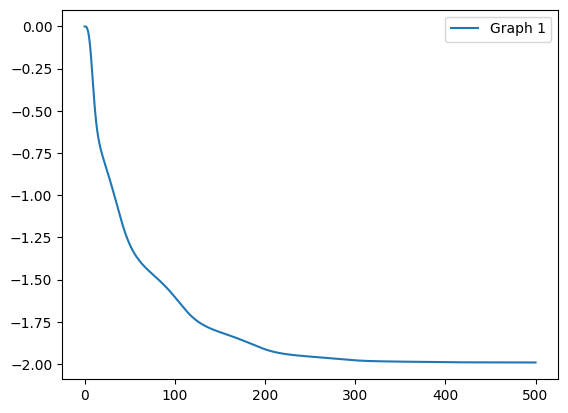

In [19]:
plt.plot(cost_function[0], label = "Graph 1")
# plt.plot(cost_function[1], label = "Graph 2")
# plt.plot(cost_function[2], label = "Graph 3")
#plt.plot(cost_function[3], label = "Graph 4")
#plt.plot(cost_function[4], label = "Graph 5")
#plt.plot(cost_function[5], label = "Graph 6")
#plt.plot(cost_function[6], label = "Graph 7")
#plt.plot(cost_function[7], label = "Graph 8")
#plt.plot(cost_function[8], label = "Graph 9")
#plt.plot(cost_function[9], label = "Graph 10")
plt.legend()
plt.show()

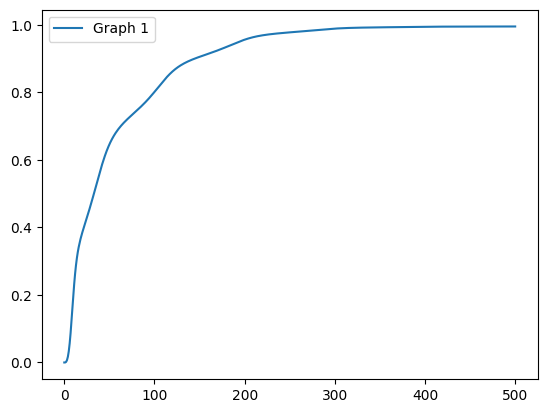

In [20]:
approximation_ratio1 = cost_function[0]/eigenValues_p[0][0]
# approximation_ratio2 = cost_function[1]/eigenValues_p[1][0]
# approximation_ratio3 = cost_function[2]/eigenValues_p[2][0]
#approximation_ratio4 = cost_function[3]/eigenValues_p[3][0]
#approximation_ratio5 = cost_function[4]/eigenValues_p[4][0]
#approximation_ratio6 = cost_function[5]/eigenValues_p[5][0]
#approximation_ratio7 = cost_function[6]/eigenValues_p[6][0]
#approximation_ratio8 = cost_function[7]/eigenValues_p[7][0]
#approximation_ratio9 = cost_function[8]/eigenValues_p[8][0]
#approximation_ratio10 = cost_function[9]/eigenValues_p[9][0]
plt.plot(approximation_ratio1, label = "Graph 1")
# plt.plot(approximation_ratio2, label = "Graph 2")
# plt.plot(approximation_ratio3, label = "Graph 3")
#plt.plot(approximation_ratio4, label = "Graph 4")
#plt.plot(approximation_ratio5, label = "Graph 5")
#plt.plot(approximation_ratio6, label = "Graph 6")
#plt.plot(approximation_ratio7, label = "Graph 7")
#plt.plot(approximation_ratio8, label = "Graph 8")
#plt.plot(approximation_ratio9, label = "Graph 9")
#plt.plot(approximation_ratio10, label = "Graph 10")
plt.legend()
plt.show()

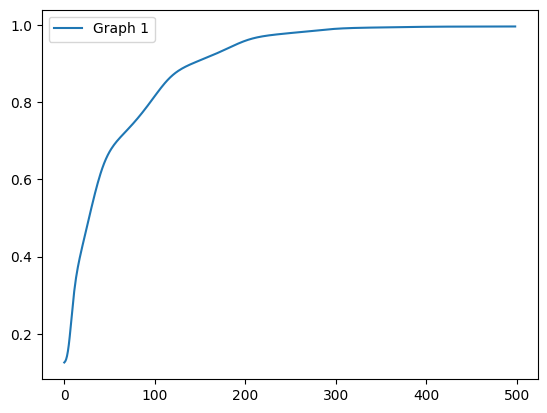

In [21]:
plt.plot(phi_list[0], label = "Graph 1")
# plt.plot(phi_list[1], label = "Graph 2")
# plt.plot(phi_list[2], label = "Graph 3")
#plt.plot(phi_list[3], label = "Graph 4")
#plt.plot(phi_list[4], label = "Graph 5")
#plt.plot(phi_list[5], label = "Graph 6")
#plt.plot(phi_list[6], label = "Graph 7")
#plt.plot(phi_list[7], label = "Graph 8")
#plt.plot(phi_list[8], label = "Graph 9")
#plt.plot(phi_list[9], label = "Graph 10")
plt.legend()
plt.show()